In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

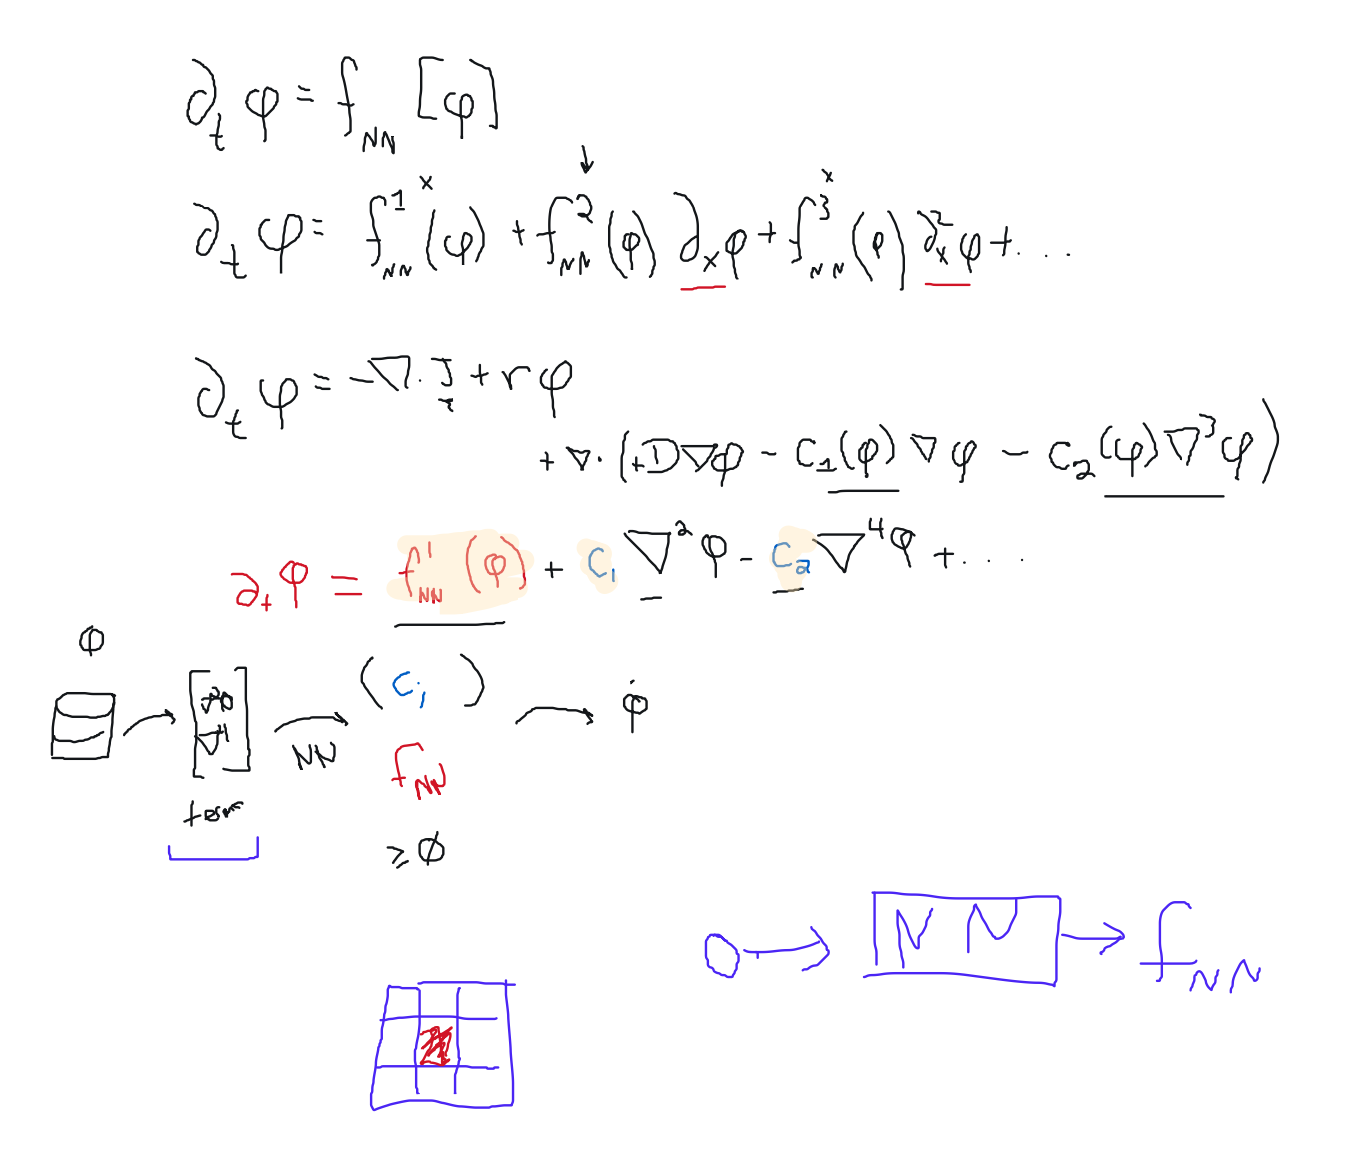

# Test FipyDataset

Pre-loading all Fipy data from files
Done (t = 5.4 s)
W0_mesh (607,)
B0_mesh (607,)
W1_mesh (607,)
B1_mesh (607,)
t0 ()
t1 ()
features_mesh List of length 2
X torch.Size([607])
Y torch.Size([607])
W0 (607,)
B0 (607,)
W1 (607,)
B1 (607,)
features torch.Size([2, 7, 607])
dt_W (607,)
dt_B (607,)
inputs torch.Size([2, 607])
targets torch.Size([2, 607])


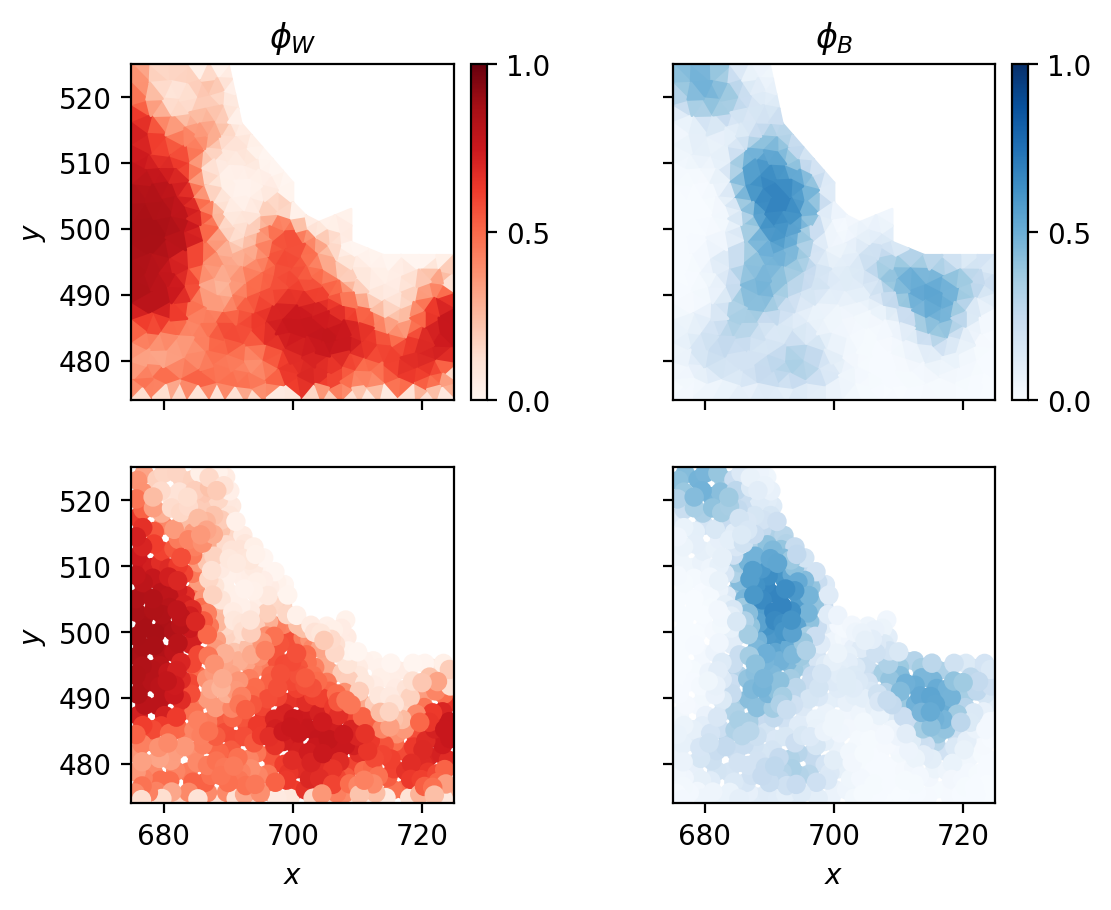

In [2]:
from fipy_dataset import FipyDataset

dataset = FipyDataset(path="./data/Illinois_Cook_small/fipy_output",
                      grid=False,
                      remove_extra=False,
                      preload=True)
sample = dataset[5]

for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        if isinstance(sample[key], list):
            print(key, 'List of length', len(sample[key]))
        else:
            print(key, sample[key])

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))

In [4]:
from fipy_nn import SociohydroParameterNetwork, ParameterNetwork
model = SociohydroParameterNetwork()
model.print()

outputs, (feature_terms, growth) = model(sample['inputs'], sample['features'], batched=False)
print(outputs.shape, feature_terms.shape, growth.shape)                                 

dt ϕW = 1 T_W + 0 k_WW + 0 k_WB + 0 ν_WWW + 0 ν_WWB + 0 ν_WBB + -1 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 1 T_B + 0 k_BB + 0 k_BW + 0 ν_BBB + 0 ν_BWB + 0 ν_BWW + -1 Γ_B + NN(['ϕW', 'ϕB'])
torch.Size([2, 607]) torch.Size([2, 607]) torch.Size([2, 607])


In [99]:
# Test new neural network with local coefficients
from fipy_nn import LocalCoefficientsParameterNetwork

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LocalCoefficientsParameterNetwork().to(device)
model.print()

outputs, (feature_terms, growth) = model(sample['inputs'].to(device), sample['features'].to(device), batched=False)
print(outputs.shape, feature_terms.shape, growth.shape)

dt ϕW = 0 ϕW_0 + 0 ϕW_1 + 0 ϕW_2 + 0 ϕW_3 + 0 ϕW_4 + 0 ϕW_5 + 0 ϕW_6 + NN(['ϕW', 'ϕB'])
dt ϕB = 0 ϕB_0 + 0 ϕB_1 + 0 ϕB_2 + 0 ϕB_3 + 0 ϕB_4 + 0 ϕB_5 + 0 ϕB_6 + NN(['ϕW', 'ϕB'])
torch.Size([2, 607]) torch.Size([2, 607]) torch.Size([2, 607])


In [98]:
from time import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing gradient computation functions
inputs = sample['inputs'][None].to(device)
ϕW = inputs[:, 0].clone().detach().requires_grad_(True)
ϕB = inputs[:, 1].clone().detach().requires_grad_(True)
inp = torch.stack([ϕW, ϕB], dim=1)

coefs = torch.empty([1, 1, 4, inputs.shape[-1]], device=device)
coefs[:, 0, 0] = 2. * inp[:, 0] + 0.5 * inp[:, 1] # Linear func
coefs[:, 0, 1] = 0.5 * inp[:, 0].pow(2) + 0.3 * inp[:, 1].pow(2) # Quadratic func
coefs[:, 0, 2] = 0.2 * inp[:, 0].pow(3) + 0.1 * inp[:, 1].pow(3) # Cubic func
coefs[:, 0, 3] = 0.7 * inp[:, 0].pow(2) * inp[:, 1].pow(7) # Mixed func

# Compute second derivative of coefs w.r.t. phi
def grad_func(output, input, **kwargs):
    t = time()
    grad_outputs = torch.ones_like(input)
    kwargs = dict(grad_outputs=grad_outputs, **kwargs)

    grad = []
    for cc in range(output.shape[1]):
        gcc = []
        for ff in range(output.shape[2]):
            gcc.append(torch.autograd.grad(output[:, cc, ff], input, **kwargs)[0])
        grad.append(torch.stack(gcc, dim=1))
    
    grad = torch.stack(grad, dim=1)
    print(f'Done, {time()-t:.2g} s', grad.shape, flush=True)
    return grad

print('-------------------------------')
print('Computing 1st order derivatives')
print('-------------------------------')

c_W = grad_func(coefs, ϕW, create_graph=True)
c_B = grad_func(coefs, ϕB, create_graph=True)
print()

# Check that 1st order derivatives are correct
print('-------------------------------')
print('1st order Verification')
print('-------------------------------')
print('Linear func:\t', 
      torch.allclose(c_W[:,:,0], torch.tensor(2.)), 
      torch.allclose(c_B[:,:,0], torch.tensor(0.5))
)
print('Quadratic func:\t', 
      torch.allclose(c_W[:,:,1], 0.5 * 2 * ϕW),
      torch.allclose(c_B[:,:,1], 0.3 * 2 * ϕB),
)
print('Cubic func:\t', 
      torch.allclose(c_W[:,:,2], 0.2 * 3 * ϕW.pow(2)),
      torch.allclose(c_B[:,:,2], 0.1 * 3 * ϕB.pow(2)),
)
print('Mixed func:\t', 
      torch.allclose(c_W[:,:,3], 0.7 * 2 * ϕW.pow(1) * ϕB.pow(7)),
      torch.allclose(c_B[:,:,3], 0.7 * 7 * ϕW.pow(2) * ϕB.pow(6)),
)
print()

print('-------------------------------')
print('Computing 2nd order derivatives')
print('-------------------------------')
c_WW = grad_func(c_W, ϕW, retain_graph=True)
c_WB = grad_func(c_W, ϕB, retain_graph=True)
c_BW = grad_func(c_B, ϕW, retain_graph=True)
c_BB = grad_func(c_B, ϕB, retain_graph=True)
print()

# Check that 1st order derivatives are correct
print('-------------------------------')
print('2nd order Verification')
print('-------------------------------')
print('Linear func:\t', 
      torch.allclose(c_WW[:,:,0], torch.tensor(0.)), 
      torch.allclose(c_WB[:,:,0], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,0], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,0], torch.tensor(0.)),
)
print('Quadratic func:\t', 
      torch.allclose(c_WW[:,:,1], torch.tensor(0.5 * 2)),
      torch.allclose(c_WB[:,:,1], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,1], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,1], torch.tensor(0.3 * 2)),
)
print('Cubic func:\t', 
      torch.allclose(c_WW[:,:,2], 0.2 * 6 * ϕW),
      torch.allclose(c_WB[:,:,2], torch.tensor(0.)),
      torch.allclose(c_BW[:,:,2], torch.tensor(0.)),
      torch.allclose(c_BB[:,:,2], 0.1 * 6 * ϕB),
)
print('Mixed func:\t', 
      torch.allclose(c_WW[:,:,3], 0.7 * 2  * ϕW.pow(0) * ϕB.pow(7)),
      torch.allclose(c_WB[:,:,3], 0.7 * 14 * ϕW.pow(1) * ϕB.pow(6)),
      torch.allclose(c_BW[:,:,3], 0.7 * 14 * ϕW.pow(1) * ϕB.pow(6)),
      torch.allclose(c_BB[:,:,3], 0.7 * 42 * ϕW.pow(2) * ϕB.pow(5)),

)
print()

-------------------------------
Computing 1st order derivatives
-------------------------------
Done, 0.0075 s torch.Size([1, 1, 4, 607])
Done, 0.0071 s torch.Size([1, 1, 4, 607])

-------------------------------
1st order Verification
-------------------------------
Linear func:	 True True
Quadratic func:	 True True
Cubic func:	 True True
Mixed func:	 True True

-------------------------------
Computing 2nd order derivatives
-------------------------------
Done, 0.017 s torch.Size([1, 1, 4, 607])
Done, 0.017 s torch.Size([1, 1, 4, 607])
Done, 0.017 s torch.Size([1, 1, 4, 607])
Done, 0.017 s torch.Size([1, 1, 4, 607])

-------------------------------
2nd order Verification
-------------------------------
Linear func:	 True True True True
Quadratic func:	 True True True True
Cubic func:	 True True True True
Mixed func:	 True True True True



In [8]:
from train_fipy_nn import JointLossFunction

loss = JointLossFunction(beta=1.)

loss(sample['targets'][None],
     sample['targets'][None],
     sample['inputs'][None],
     sample['inputs'][None],
     sample['inputs'][None])

tensor(0.6783)

# Test CensusDataset

Pre-loading all Fipy data from files
Done (t = 0.4 s)
W0_mesh (997,)
B0_mesh (997,)
W1_mesh (997,)
B1_mesh (997,)
t0 2012
t1 2013
features_mesh List of length 2
X torch.Size([997])
Y torch.Size([997])
W0 (997,)
B0 (997,)
W1 (997,)
B1 (997,)
features torch.Size([2, 7, 997])
dt_W (997,)
dt_B (997,)
inputs torch.Size([2, 997])
targets torch.Size([2, 997])


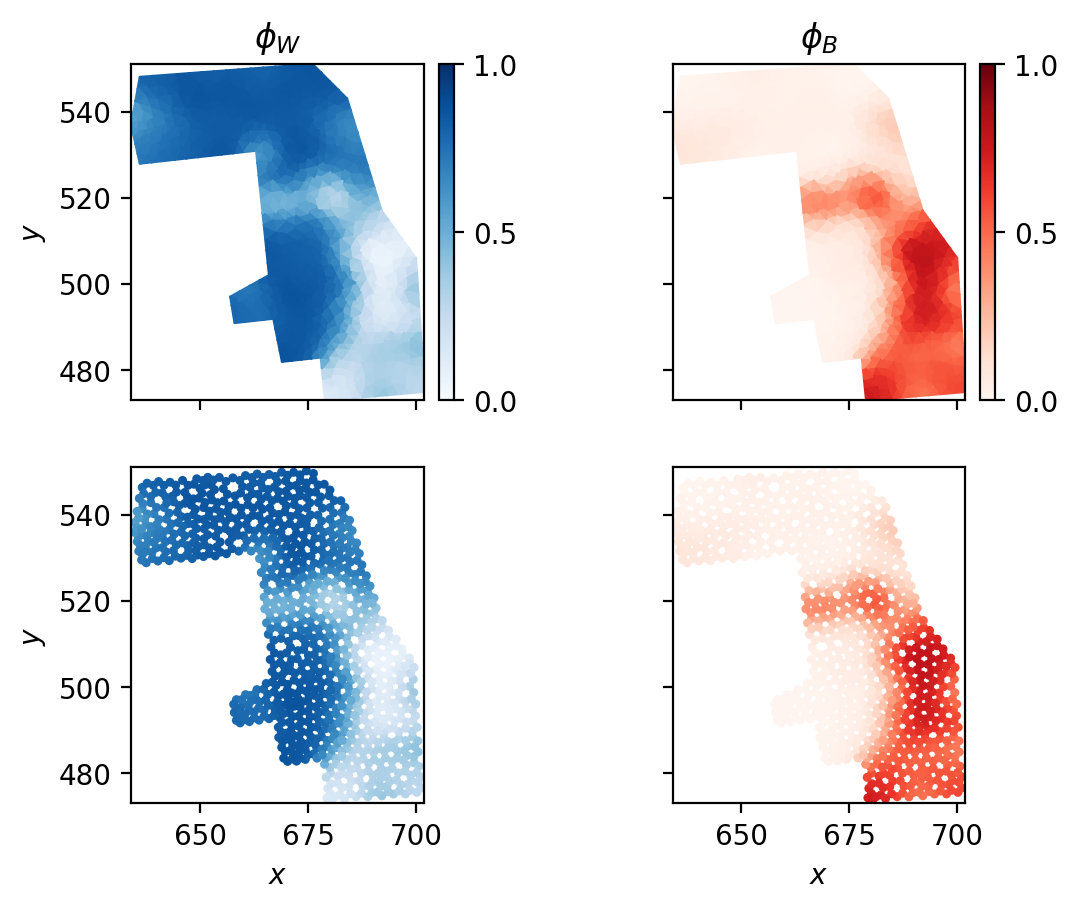

In [30]:
from census_dataset import CensusDataset

dataset = CensusDataset(path="/project/vitelli/dsseara/schelling/data/yearly/raw/meshed/Illinois_Cook",
                        grid=False,
                        remove_extra=False,
                        preload=True,
                        region="county",
                        sigma=10.0)
sample = dataset[2]

for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        if isinstance(sample[key], list):
            print(key, 'List of length', len(sample[key]))
        else:
            print(key, sample[key])

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1],
          cmap=plt.cm.Reds, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['inputs'][0],
                        cmap='Blues', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['inputs'][1],
                        cmap='Reds', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0],
                     s=5, cmap='Blues', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1],
                     s=5, cmap='Reds', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in fig.axes:
    a.set_aspect(1)

In [28]:
from fipy_nn import SociohydroParameterNetwork, ParameterNetwork
model = SociohydroParameterNetwork()
model.print()

outputs, _ = model(sample['inputs'], sample['features'], batched=False)
print(outputs.shape)                                 

dt ϕW = 1 T_W + 0 k_WW + 0 k_WB + 0 ν_WWW + 0 ν_WWB + 0 ν_WBB + -1 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 1 T_B + 0 k_BB + 0 k_BW + 0 ν_BBB + 0 ν_BWB + 0 ν_BWW + -1 Γ_B + NN(['ϕW', 'ϕB'])
torch.Size([2, 6840])


In [29]:
from train_fipy_nn import JointLossFunction

loss = JointLossFunction(beta=1.)

loss(sample['targets'][None],
     sample['targets'][None],
     sample['inputs'][None],
     sample['inputs'][None],
     sample['inputs'][None])

tensor(1.2595)

In [34]:
import datetime
dt = datetime.datetime.now()
dt.strftime('%Y%m%d_%H%M')

'20240830_1709'